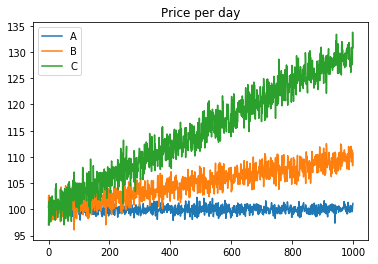

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pulp import LpProblem, LpVariable, LpStatus, lpSum, lpDot, value

np.random.seed(1)
n = 1000 # Days

data = np.random.multivariate_normal(
    [100, 100, 100],
    [
        [0.5, 0, 0.1],
        [0,2, -2],
        [0.1, -2, 4]
    ], n)
data[:,1] += np.linspace(0,(n-1)*0.01, n)
data[:,2] += np.linspace(0,(n-1)*0.03, n)

a = pd.DataFrame(data, columns=['A', 'B', 'C'])
a.plot(title='Price per day')

plt.show()

In [10]:
b = a.diff()[1:] / a[:-1].values  # Return per day
b.describe() * 1000


,A,B,C
count,999000.000000,999000.000000,999000.000000
mean,0.054816,0.270160,0.593924
std,9.752859,19.587474,24.358825
min,-38.291100,-59.865193,-71.984540
25%,-6.417058,-13.347788,-16.146668
50%,0.334623,0.540288,-0.506655
75%,6.376544,13.579641,16.645238
max,35.394784,65.592573,103.441891


In [11]:
x = [LpVariable('x%06d' % i, lowBound=0, upBound=1)
     for i in range(a.shape[1])] # Portofolio balance

b['y'] = [LpVariable('y%06d' % i, lowBound=0) for i in range(n-1)]

for profit in [0.06, 0.2, 0.57]:
    m = LpProblem() # Minimize Risk
    m += lpSum(b.y) # Purpose
    m += lpSum(x) == 1 # Sum of each stocks will be 1
    m += lpDot(b.sum(), x) == profit
    
    for _, r in b.iterrows():
        m += r.y >= lpDot(r,x) - profit
        m += r.y >= profit - lpDot(r,x)
        
    m.solve()
    r = np.vectorize(value)(x).round(3)
    
    print(f'Status={LpStatus[m.status]} Return={value(lpDot(b.sum(),x)):.3f} '
          f'Risk={value(m.objective):.3f} Portofolio={r}')


Status=Optimal Return=0.060 Risk=59.880 Portofolio=[ 0.976  0.024  0.   ]
Status=Optimal Return=0.200 Risk=199.600 Portofolio=[ 0.325  0.675  0.   ]
Status=Optimal Return=0.570 Risk=568.860 Portofolio=[ 0.     0.072  0.928]
